**This notebook is focussed on utilizing annoy library to generate labels for unlabelled images**

- Use *realestate-classification-rn50* pretrained model to generate activations for unlabelled test images
- Create annoy index for those images
- Pass sample image from train data to annoy function to get 120-30 most similar images from test data.
- Label those 20-30 images with the label of sample train image

In [689]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from annoy import AnnoyIndex
import matplotlib.pyplot as plt

In [690]:
PATH = Path('batch_images')
PATH

PosixPath('batch_images')

**Load Train Data**

In [655]:
train_df = pd.read_csv('train_data.csv')
train_df.drop(columns = ['Unnamed: 0'],axis = 1, inplace=True)
train_df.head(), train_df.shape

(       image_path correct_labels  valid
 0   5_/5000/0.jpg       Exterior  False
 1   5_/5000/1.jpg        kitchen  False
 2  5_/5000/10.jpg       Exterior  False
 3  5_/5000/11.jpg       Exterior  False
 4  5_/5000/12.jpg       Exterior  False, (4240, 3))

In [656]:
valid_df = pd.read_excel('valid.xlsx')
valid_df.drop(columns = ['predicted_labels'],axis = 1, inplace=True)
valid_df.dropna(thresh=2, inplace=True)
valid_df['valid'] = True
valid_df.head(), valid_df.shape

(       image_path correct_labels  valid
 0   7_/7000/0.jpg       Exterior   True
 1   7_/7000/1.jpg       Exterior   True
 2  7_/7000/10.jpg        kitchen   True
 3  7_/7000/11.jpg        kitchen   True
 4  7_/7000/12.jpg       Interior   True, (295, 3))

In [657]:
df = train_df.append(valid_df,ignore_index=True)
df.tail()

,image_path,correct_labels,valid
4530,7_/7015/5.jpg,living_room,True
4531,7_/7015/6.jpg,bathroom,True
4532,7_/7015/7.jpg,bedroom,True
4533,7_/7015/8.jpg,bathroom,True
4534,7_/7015/9.jpg,bedroom,True


In [652]:
test_df = pd.read_csv('train_9_null.csv')
test_df.drop(columns = ['correct_labels','Unnamed: 0'],axis = 1, inplace=True)
test_df.head(),test_df.shape

(       image_path
 0   9_/9000/0.jpg
 1   9_/9000/1.jpg
 2  9_/9000/11.jpg
 3  9_/9000/12.jpg
 4  9_/9000/13.jpg, (17768, 1))

In [653]:
def get_activations(m, x):
    "Return activations of the penultimate layer after forward pass of an image through CNN"
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    with hook_output(m[0]) as hook_a: 
        preds = m(xb)
    acts  = hook_a.stored[0].cpu()
    return acts

In [654]:
def create_subdata(ds, size=10000, seed=42):
    "Returns a subset of the dataset"
    sub_ds = []
    np.random.seed(seed)
    for i in range(size):
        idx = np.random.randint(0, 100000)
        x, y = ds[idx]
        sub_ds.append({'x': x, 'y': y})
    return sub_ds

**Generate Data Bunch**

In [658]:
np.random.seed(42)
data = (ImageList.from_df(df,PATH/'').split_from_df(col='valid')
       .label_from_df().add_test(ImageList.from_df(test_df,PATH)).transform(get_transforms(do_flip=False),size=224)
        .databunch(bs=4).normalize(imagenet_stats))

In [659]:
data.sanity_check

<bound method DataBunch.sanity_check of ImageDataBunch;

Train: LabelList (4240 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Exterior,kitchen,Exterior,Exterior,Exterior
Path: batch_images;

Valid: LabelList (295 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Exterior,Exterior,kitchen,kitchen,Interior
Path: batch_images;

Test: LabelList (17768 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: batch_images>

In [660]:
# number of classes
print(f'Dataset has {data.c} classes: {data.classes}')

Dataset has 7 classes: ['Exterior', 'Interior', 'bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room']


**Load Pretrained Model**

We set it to eval stage in order to get activations for test images

In [661]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy ,model_dir = '/home/fellowship_ai/models').load('realestate-classification-rn50')

In [662]:
m = learn.model.eval()

In [663]:
sub_ds = data.test_ds

In [664]:
# get the flattened activations from the penultimate layer of the CNN for images
x_new = []
m = learn.model.eval()
for idx in range(len(sub_ds)):
    x = sub_ds.x[idx]
    x_new.append(get_activations(m, x).mean(1).mean(1).flatten())
    
new_dims = len(x_new[0])
print(f'Dimensions of the activations (penultimate layer): {new_dims}')

Dimensions of the activations (penultimate layer): 2048


In [665]:
# create index of the all the images (reduced space)
f = new_dims
t = AnnoyIndex(f)
for i, x in enumerate(x_new):
    t.add_item(i, x)
# build 100 trees. More number of trees means higher precision (requires higher RAM)
t.build(n_trees=500)   
# save the index on the disk for reuse later
t.save('realestate-500-index9.ann')

True

**Annoy Search**

In [666]:
# Load the saved annoy index
index = AnnoyIndex(2048)
index.load('realestate-500-index9.ann') # super fast, will just mmap the file

True

In [667]:
import warnings
warnings.filterwarnings('ignore')

In [668]:
# function to search for similar images using annoy and plot them
def plot_similar(idx, test_ds, train_ds, test_df, annoy_index, k=5):
    
    print(f'Sample Train Image: {train_ds.y[idx]}')
    
    #test_df['label']  = []
    "Search and Plot `k` similar images for given image using approx. nearest neighbor search (annoy)"
    x = train_ds.x[idx]
    
    # get activations for the image
    v = get_activations(m, x).mean(1).mean(1).flatten()

    # get 5-nearest neighbor
    x_sim = annoy_index.get_nns_by_vector(v, k)
    print(f'{k} images most similar to sample train image are {x_sim} (test set)')
    
    # plotting the similar images
    n = 1+len(x_sim)
    plt.figure(figsize=(100, 10))
    ax = plt.subplot(1, n, 1)
    show_image(x, ax)
    idx_list = []
    for i, j in enumerate(x_sim):
        ax = plt.subplot(1, n, i+2)
        show_image(test_ds.x[j], ax)
        idx_list.append(j) #test_df.loc[test_df.image_path == test_ds.x.items[j].split('es/')[1]].index)
    return idx_list, train_ds.y[idx]

**Find 20-30 most similar images corresponding to input train image index** 

Train *idx* is chosen from initial manually labelled dataset. We randomly choose idx of any one room type at a time**

Sample Train Image: living_room
20 images most similar to sample train image are [8364, 13468, 13977, 560, 8315, 4129, 1807, 9529, 6223, 11617, 8917, 8955, 15343, 5749, 8848, 4095, 1910, 5185, 8761, 8920] (test set)


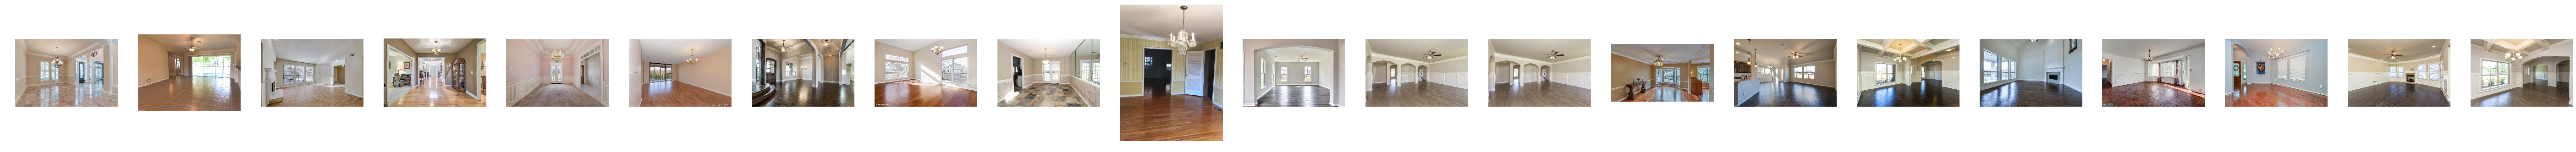

In [683]:
idx = 694 #random.randint(0, len(data.train_ds.x))
idx_list, label = plot_similar(idx, data.test_ds, data.train_ds, test_df, annoy_index=index,k=20)

**Above, we verify images visually and then add labels to test image in bulk**

In [684]:
for ind in idx_list:
    if pd.isnull(test_df.loc[ind,'correct_labels']):
        test_df.loc[ind,'correct_labels'] = str(label)

In [685]:
test_df[test_df['correct_labels'].isnull()].shape

(17708, 2)

In [686]:
test_df.loc[test_df['correct_labels'].notnull()].shape

(60, 2)

In [687]:
test_df.groupby('correct_labels').count()

,image_path
correct_labels,
kitchen,40
living_room,20


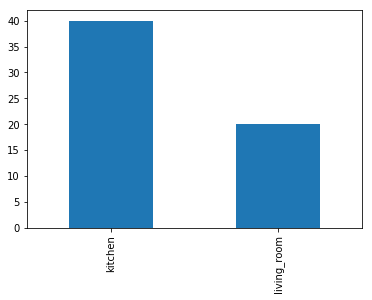

In [688]:
pd.value_counts(test_df['correct_labels']).plot.bar()

In [605]:
test_df.loc[test_df['correct_labels'].isnull()].to_csv('9_null.csv')